In [219]:
import numpy as np
import pandas as pd
import warnings
from matplotlib import pylab as plt
from matplotlib import pyplot
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
import string
import random

warnings.simplefilter(action='ignore', category=FutureWarning)

def tokenize_text(text):
    tokens = ''
    for word in nltk.word_tokenize(text):
        if len(word) < 2:
            continue
        tokens += word + ' '
    return tokens

def class_simple_balancer(df, num_samples_in_class = 500):
    df = df.drop_duplicates()
    df_new = pd.DataFrame()

    for index, gr in df.groupby('category_id'):
        ln = len(gr)
        if ln < num_samples_in_class:
            k = num_samples_in_class//ln + 1
            df_new = df_new.append([gr]*k, ignore_index = True)
        else:
            df_new = df_new.append(gr.sample(frac=1).iloc[:num_samples_in_class, :], ignore_index = True)
    return df_new

def create_sentence(element_weights, values, k = 5):
    s = ''
    index = random.choices(range(0, len(values)), weights=element_weights, k=k)
    for word in list(values[index]):
        s += word + ' '
    return s

def class_weights_balancer(df, num_samples_in_class = 500):
    df = df.drop_duplicates()
    df_new = pd.DataFrame()

    for index, gr in df.groupby('category_id'):
        ln = len(gr)
        if ln < num_samples_in_class:
            element_weight = gr[['category_id']].join(gr['item_name'].str.split().
                                           explode()).groupby('item_name').apply(len)
            df_new = df_new.append(gr, ignore_index=True)
            for i in range(0, binn - ln):
                n = random.randint(1, 6)
                df_new = df_new.append({'category_id' : index, 'item_name' : 
                                        create_sentence(element_weight.values,
                                                        element_weight.index.values, n)}, ignore_index=True)
        else:
            df_new = df_new.append(gr.sample(frac=1).iloc[:num_samples_in_class, :], ignore_index = True)
    return df_new

def draw_classes_intersections(df):
    wdf = df[['category_id']].join(df['item_name'].str.split().explode())
    wc_stat = wdf.groupby('category_id').apply(lambda g: g.item_name.unique())
    stat = []
    for indx1, cat1 in wc_stat[:-1].items():
        for indx2, cat2 in wc_stat[1:].items():
            stat.append({'cc' : str(indx1) + "_" + str(indx2),
                         'freq' : len(np.intersect1d(cat1, cat2))/len(set(cat1) | set(cat2))})
        
    stat = pd.DataFrame(stat)
    _ = plt.hist(stat[stat.freq < 1.0].freq, bins = 100)

# Load data, remove step words, extrat corpus words

In [220]:
df = pd.read_csv('clean_data_fusion.csv', index_col = 0)
#df['item_name'] = df['item_name'].apply(tokenize_text)

stop = stopwords.words('russian')
freq = CountVectorizer(stop_words=stop, binary = True)
freq.fit_transform(df.item_name.drop_duplicates())
words = pd.DataFrame.from_dict([freq.vocabulary_]).T.sort_index().index

# Show categories distirbution

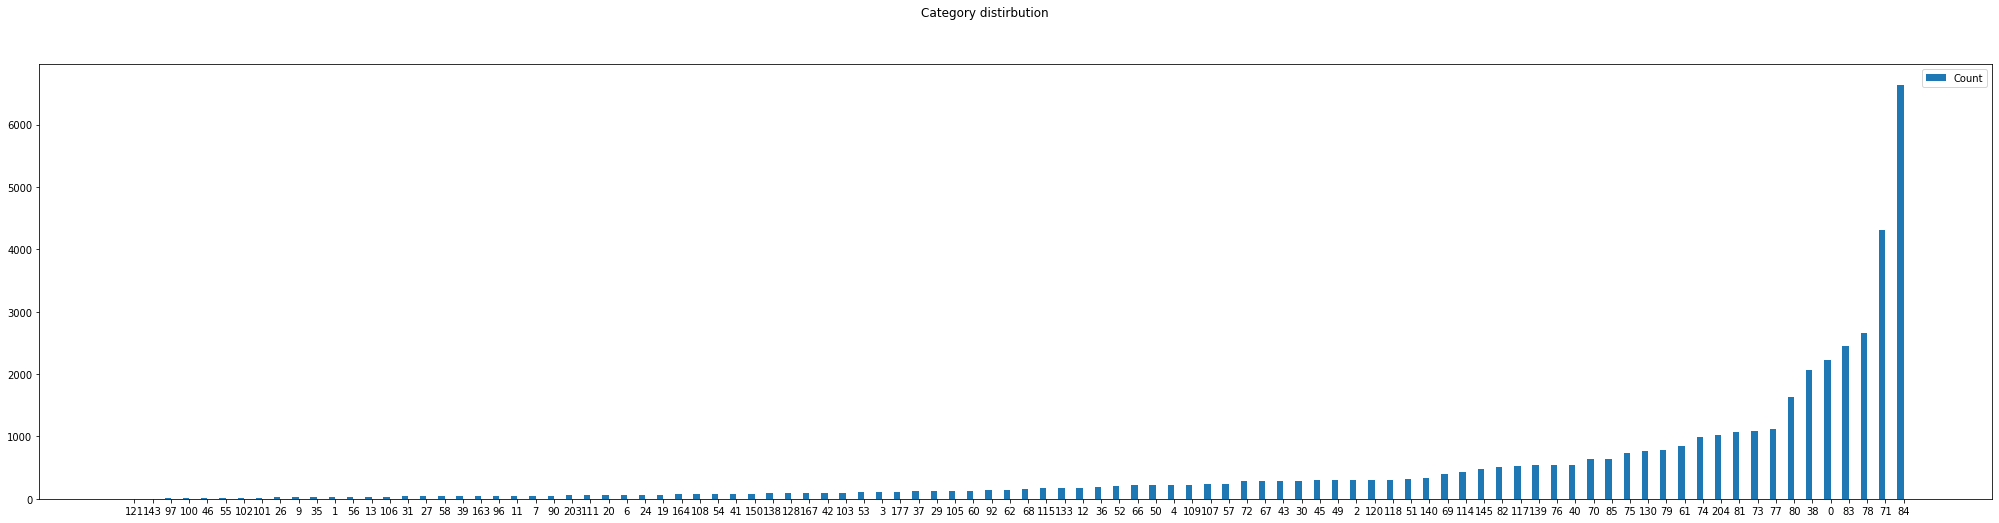

In [221]:
s = df.drop_duplicates().groupby('category_id').apply(len).sort_values()

fig = pyplot.figure()
ind = np.arange(len(s))
width = 0.35
fig.suptitle('Category distirbution')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, s, width=width, label='Count')
fig.set_size_inches(35,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(s.index)
pyplot.show()

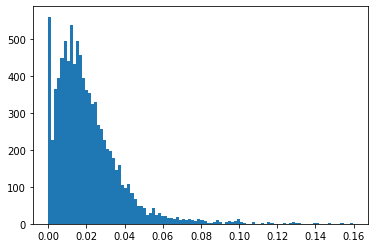

In [222]:
draw_classes_intersections(df)